In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.patches import Ellipse, Circle
import math
import sympy as sym

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

## Create dataset ##

def arr2poly(arr):
    string = ''
    head = True
    for i in range(4):
        if arr[i] == 0:
            continue
            
        if arr[i] > 0 and i < 2:
            if head:
                string += str(arr[i]) + '*x**' + str(3-i)
            else:
                string += '+' + str(arr[i]) + '*x**' + str(3-i)
            head = False
                
        if arr[i] < 0 and i < 2:
            #print('here')
            string += str(arr[i]) + '*x**' + str(3-i)
            head = False
            
        if arr[i] > 0 and i == 2:
            if head:
                string += str(arr[i]) + '*x'
            else:
                string += '+' + str(arr[i]) + '*x'
            head = False
                
        if arr[i] < 0 and i == 2:
            string += str(arr[i]) + '*x'
            head = False
            
        if arr[i] > 0 and i == 3:
            if head:
                string += str(arr[i])
            else:
                string += '+' + str(arr[i])
            head = False
                
        if arr[i] < 0 and i == 3:
            if head:
                string += str(arr[i])
            else:
                string += '+' + str(arr[i])
            head = False

    if string == '':
        string = '0'
            
    return string

def formula2tokens(string):
    i = 0
    num_list = [str(i) for i in range(10)]
    tokens = []
    
    while i < len(string):
        char = string[i]
        if char in num_list:
            token = ''
            while string[i] in num_list:
                token += string[i]
                i += 1
                if i == len(string):
                    break
            tokens.append(token)

        if char == ' ':
            i += 1

        if char == '+' or char == '-':
            i += 1
            tokens.append(char)

        if char == '*':
            token = ''
            while string[i] == '*':
                token += string[i]
                i += 1
            tokens.append(token)

        if char == 'x':
            i += 1
            tokens.append(char)
            
    return tokens

# tokenization
token_lib = [str(i) for i in range(11)] + ['x', '*', '**', '+', '-', '?', '.', 'p']
dic = {}
i = 0
for char in token_lib:
    dic[char] = i
    i += 1
    
def token2tokenid(tokens):
    token_ids = []
    for token in tokens:
        token_ids.append(dic[token])
    return token_ids

def arr2tokenid(arr):
    x = sym.Symbol('x')
    original = str(arr2poly(arr))
    derivative = str(sym.diff(original,x))
    original_tokenid = token2tokenid(formula2tokens(original))
    derivative_tokenid = token2tokenid(formula2tokens(derivative))
    whole_tokenid = original_tokenid + [dic['?']] + derivative_tokenid + [dic['.']]
    return original_tokenid, derivative_tokenid, whole_tokenid, len(original_tokenid) + 1


import numpy as np
a3 = np.linspace(-2,2,num=5).astype(int)
a2 = np.linspace(-5,5,num=11).astype(int)
a1 = np.linspace(-10,10,num=21).astype(int)
a0 = np.linspace(-10,10,num=21).astype(int)
A3, A2, A1, A0 = np.meshgrid(a3, a2, a1, a0)
arrs = np.transpose(np.array([A3.reshape(-1,), A2.reshape(-1,), A1.reshape(-1,), A0.reshape(-1,)]))

token_ids = []
question_lens = []
for i in range(arrs.shape[0]):
    if i % 2000 == 0:
        print(i)
    _, _, wholetokenid, question_len = arr2tokenid(arrs[i])
    token_ids.append(wholetokenid)
    question_lens.append(question_len)
    
lens = []
for i in range(arrs.shape[0]):
    lens.append(len(token_ids[i]))
    
max_len = max(lens)

for i in range(arrs.shape[0]):
    if lens[i] < max_len:
        token_ids[i] = token_ids[i] + [dic['p']] * (max_len - lens[i])
        
token_ids = np.array(token_ids)

num = token_ids.shape[0]
train_frac = 0.8
train_num = int(num*train_frac)

train_id = np.random.choice(num, train_num, replace=False)
test_id = np.array(list(set(list(np.arange(num))) - set(train_id)))

train_token_ids = token_ids[train_id]
test_token_ids = token_ids[test_id]

masks = []
for question_len in question_lens:
    mask = [0] * (question_len - 1) + [1] * (max_len - question_len)
    masks.append(mask)
    
masks = np.array(masks)
train_mask = masks[train_id]
test_mask = masks[test_id]

train_token_ids = torch.from_numpy(train_token_ids)
test_token_ids = torch.from_numpy(test_token_ids)

train_mask = torch.from_numpy(train_mask)
test_mask = torch.from_numpy(test_mask)

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000


In [2]:
## network ##

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

torch.set_default_tensor_type(torch.DoubleTensor)

class MLP(nn.Module):
    def __init__(self, in_dim=2, out_dim=2, w=2, depth=2, shp=None):
        super(MLP, self).__init__()
        if shp == None:
            shp = [in_dim] + [w]*(depth-1) + [out_dim]
            self.in_dim = in_dim
            self.out_dim = out_dim
            self.depth = depth
                 
        else:
            self.in_dim = shp[0]
            self.out_dim = shp[-1]
            self.depth = len(shp) - 1
        linear_list = []
        for i in range(self.depth):
            linear_list.append(nn.Linear(shp[i], shp[i+1]))
        self.linears = nn.ModuleList(linear_list)
        self.shp = shp
    
    def forward(self, x):
        f = lambda x: 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))
        #f = torch.nn.SiLU()
        for i in range(self.depth-1):
            x = f(self.linears[i](x))
        x = self.linears[-1](x)
        return x
    
    def get_linear_layers(self):
        return self.linears
    
class Attention(nn.Module):
    def __init__(self, n_head=2, n_embed=6):
        super().__init__()
        assert n_embed % n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.l_attn = nn.Linear(n_embed, 3*n_embed)
        # output projection
        self.l_proj = nn.Linear(n_embed, n_embed)
        self.n_head = n_head
        self.n_embed = n_embed

    def forward(self, x):
        # B: batch size; T: sequence length; C: embedding dimensionality (n_embd)
        B, T, C = x.size()

        # query, key, value
        x = self.l_attn(x)
        q, k, v = x[:,:,:C], x[:,:,C:2*C], x[:,:,2*C:3*C]
        n_head = self.n_head
        assert C % n_head == 0
        q = q.reshape(B, T, n_head, int(C/n_head))
        k = k.reshape(B, T, n_head, int(C/n_head))
        v = v.reshape(B, T, n_head, int(C/n_head))

        # (causal) self-attention
        attn = torch.einsum('ijhl,ikhl->ijkh', q, k)/np.sqrt(int(C/n_head))
        mask = torch.ones(T,T)*float('-inf')
        mask = torch.tril(mask, diagonal=-1).permute(1,0).unsqueeze(dim=0).unsqueeze(dim=3)
        attn = attn + mask
        attn = nn.Softmax(dim=2)(attn)
        attn = torch.einsum('ijkl,iklh->ijlh', attn, v)
        attn = attn.reshape(B, T, C)

        # output projection
        y = self.l_proj(attn)
        return y
    
    def get_linear_layers(self):
        return [self.l_attn, self.l_proj]
    
    
class Block(nn.Module):
    # A transformer block
    def __init__(self, n_head=2, n_embed=6):
        super().__init__()
        self.n_head = n_head
        self.n_embed = n_embed
        self.ln_1 = nn.LayerNorm(n_embed)
        self.attn = Attention(n_head=n_head, n_embed=n_embed)
        self.ln_2 = nn.LayerNorm(n_embed)
        self.mlp = MLP(shp=[n_embed, 4*n_embed, n_embed])

    def forward(self, x):
        #x = x + self.attn(self.ln_1(x))
        #x = x + self.mlp(self.ln_2(x))
        #x = self.attn(self.ln_1(x))
        #x = self.mlp(self.ln_2(x))
        x = x + self.attn(x)
        x = x + self.mlp(x)
        return x
    
    def get_linear_layers(self):
        return [self.ln_1, *self.attn.get_linear_layers(), self.ln_2, *self.mlp.get_linear_layers()]
    
    
class Transformer(nn.Module):
    # Transformer: since our goal is to deal with linear regression, not language, 
    # we ignore token embeddings and positioanl embeddings. 
    def __init__(self, out_dim=19, n_head=2, n_embed=20, n_layer=2):
        super().__init__()
        self.n_head = n_head
        self.n_embed = n_embed
        self.n_layer = n_layer
        self.l_i = nn.Linear(n_embed, n_embed)
        self.blocks = nn.ModuleList([Block(n_head=n_head, n_embed=n_embed) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embed)
        self.l_f = nn.Linear(n_embed, out_dim)
        self.in_dim = n_embed
        self.out_dim = out_dim
        self.embedding = nn.Parameter(torch.normal(0,1,size=(19,n_embed))) # 19 tokens in token_lib
        

    def forward(self, token_ids):
        x = self.embedding[token_ids]
        x = self.l_i(x)
        for i in range(self.n_layer):
            x = self.blocks[i](x)
        y = self.l_f(x)
        return y
    
def loss_(model, mode='train', batch_size=64):
    if mode == 'train':
        token_ids = train_token_ids
        mask = train_mask
    else:
        token_ids = test_token_ids
        mask = test_mask
    
    ids = np.random.choice(token_ids.shape[0], batch_size, replace=False)
    x = token_ids[ids,:-1]
    pred = model(x)
    label = token_ids[ids,1:]
    batch_mask = mask[ids]

    batch = pred.shape[0]
    length = pred.shape[1]
    token_num = pred.shape[2]
    CE = nn.CrossEntropyLoss(reduce=False)

    wo_mask_loss = CE(pred.reshape(batch*length, token_num), label.reshape(-1,))
    wo_mask_loss = wo_mask_loss.reshape(batch, length)
    wo_mask_loss_av = torch.mean(wo_mask_loss)
    w_mask_loss = wo_mask_loss * batch_mask
    w_mask_loss_av = torch.sum(w_mask_loss)/torch.sum(batch_mask)

    pred_id = torch.argmax(pred, dim=2)
    wo_mask_acc = torch.sum(pred_id == label)/(label.reshape(-1).shape[0])
    w_mask_acc = torch.sum((pred_id == label)*batch_mask)/torch.sum(batch_mask)
    w_mask_acc_eq = torch.mean((torch.sum((pred_id == label)*batch_mask, dim=1) == torch.sum(batch_mask, dim=1)).float())
    return w_mask_loss_av, w_mask_acc, w_mask_acc_eq



In [3]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

t = Transformer(n_embed=32, n_head=4, n_layer=2)

steps = 10000
log = 100
batch_size = 1024
optimizer = torch.optim.Adam(t.parameters(), lr=0.001)

train_losses = []
test_losses = []
train_accs = []
test_accs = []
train_acc_eqs = []
test_acc_eqs = []

for step in range(steps):
    
    if step == 5000:
        for g in optimizer.param_groups:
            g['lr'] *= 0.1
    
    optimizer.zero_grad()
    train_loss, train_acc, train_acc_eq = loss_(t, mode='train', batch_size=batch_size)
    test_loss, test_acc, test_acc_eq = loss_(t, mode='test', batch_size=batch_size)
    train_loss.backward()
    optimizer.step()
    
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    
    train_accs.append(train_acc.item())
    test_accs.append(test_acc.item())
    
    train_acc_eqs.append(train_acc_eq.item())
    test_acc_eqs.append(test_acc_eq.item())
    
    if step % log == 0:
        print(" step: %d | train loss: %.2e | test loss: %.2e | train acc: %.2e | test acc: %.2e | train eq acc: %.2e | test eq acc: %.2e  "%(step, train_loss.item(), test_loss.item(), train_acc.item(), test_acc.item(), train_acc_eq.item(), test_acc_eq.item()))

/state/partition1/llgrid/pkg/anaconda/anaconda3-2023a-pytorch/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 step: 0 | train loss: 3.11e+00 | test loss: 3.11e+00 | train acc: 3.94e-02 | test acc: 3.91e-02 | train eq acc: 0.00e+00 | test eq acc: 0.00e+00  
 step: 100 | train loss: 6.02e-01 | test loss: 5.71e-01 | train acc: 7.71e-01 | test acc: 7.85e-01 | train eq acc: 0.00e+00 | test eq acc: 0.00e+00  
 step: 200 | train loss: 4.85e-01 | test loss: 4.77e-01 | train acc: 8.19e-01 | test acc: 8.25e-01 | train eq acc: 0.00e+00 | test eq acc: 0.00e+00  
 step: 300 | train loss: 3.54e-01 | test loss: 3.38e-01 | train acc: 8.79e-01 | test acc: 8.82e-01 | train eq acc: 3.32e-02 | test eq acc: 3.52e-02  
 step: 400 | train loss: 2.78e-01 | test loss: 2.70e-01 | train acc: 9.04e-01 | test acc: 9.08e-01 | train eq acc: 6.64e-02 | test eq acc: 7.23e-02  
 step: 500 | train loss: 2.25e-01 | test loss: 2.25e-01 | train acc: 9.23e-01 | test acc: 9.24e-01 | train eq acc: 1.30e-01 | test eq acc: 1.37e-01  
 step: 600 | train loss: 1.96e-01 | test loss: 2.09e-01 | train acc: 9.34e-01 | test acc: 9.31e-01 | t

KeyboardInterrupt: 

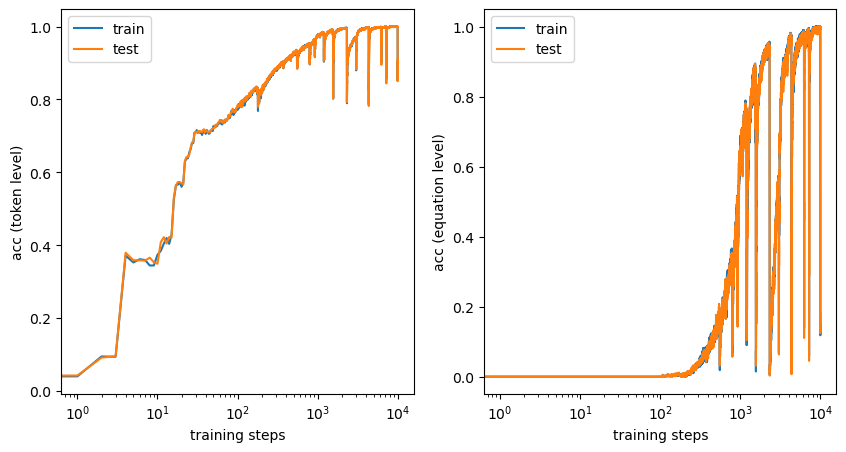

In [33]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)

plt.plot(np.arange(steps,), train_accs)
plt.plot(np.arange(steps,), test_accs)
plt.xscale('log')
plt.xlabel('training steps')
plt.ylabel('acc (token level)')
plt.legend(['train', 'test'])

plt.subplot(1,2,2)

plt.plot(np.arange(steps,), train_acc_eqs)
plt.plot(np.arange(steps,), test_acc_eqs)
plt.xscale('log')
plt.xlabel('training steps')
plt.ylabel('acc (equation level)')
plt.legend(['train', 'test'])

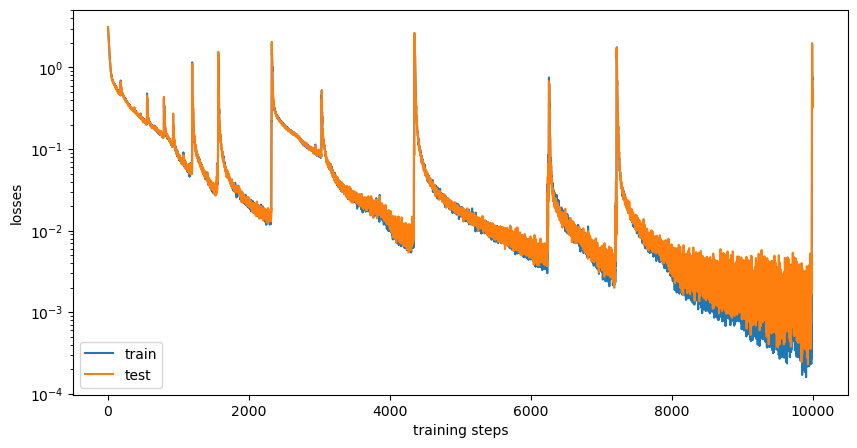

In [37]:
plt.figure(figsize=(10,5))

plt.plot(np.arange(steps,), train_losses)
plt.plot(np.arange(steps,), test_losses)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('training steps')
plt.ylabel('losses')
plt.legend(['train', 'test'])

In [31]:
np.array(token_lib)[token_ids[0]]

array(['-', '2', '*', 'x', '**', '3', '-', '5', '*', 'x', '**', '2', '-',
       '10', '*', 'x', '+', '-', '10', '?', '-', '6', '*', 'x', '**', '2',
       '-', '10', '*', 'x', '-', '10', '.'], dtype='<U2')